In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
def prepare_data(df):
    """
    preprocess data 
    - seprate features and labels data
    - split data into train and test sets
    - scale data
    
    param: a dataframe of input data
    output: X_train_scaled, X_test_scaled, y_train, y_test
    """
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42,  stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

In [ ]:
def design_model(input_dim, learning_rate):
    """
    build the model architecture and compile it 
    
    param: number of features
    output: keras model object
    """
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    #classifier.add(layers.Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    #classifier.add(layers.Dropout(0.3))
    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def fit_model(model, X_train, y_train, epochs, batch_size, patience):
    """
    train our model on the training data
    
    param:
        X_train: training set's features
        y_train: training set's labels
        
    output: model's history
    """
#     model = design_model(X_train.shape[1], learning_rate)
    earlystop_callback = EarlyStopping(monitor="val_accuracy", mode="max", min_delta=0.0001, patience=patience, verbose=1)
#     history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[es])
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[earlystop_callback],
                        validation_split=0.2,
                        verbose=1)

    return history

In [ ]:
def plot_learning_curve(history, param, learning_rate):
    """
    show how the model performs (in term of accuracy and loss) over several epochs.
    """
    if param == "loss":
        plt.plot(history.history["loss"], label="train")
        plt.plot(history.history["val_loss"], label="validation")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.tight_layout()
        plt.show()
        plt.savefig("my_plot.png")
    elif param == "acc":
        plt.plot(history.history["accuracy"], label="train")
        plt.plot(history.history["val_accuracy"], label="validation")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.tight_layout()
        plt.show()
        plt.savefig("my_plot.png")
        

In [36]:
def grid_search(X_train, y_train, num_features, learning_rate):
    """
    use grid search for hyperparamter tuning in neural network
    
    param: 
        X_train: training set's features
        y_train: training set's labels
        num_features: input dimension
        learning_rate: learning rate
    output: best parameters within our grid search
    """
    # create model
    model = KerasClassifier(build_fn=design_model, input_dim=num_features, learning_rate=learning_rate, verbose=0)

    # define the grid search parameters
    batch_size = [1024, 2024]
    epochs = [20, 60]
    
    param_grid = dict(batch_size=batch_size, epochs=epochs)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X_train, y_train)
    
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
    return grid_result.best_params_

In [37]:
def main():
    """
    drives the entire code (prepare data, build model, evaluate model and predicts on the test set) 
    and plot some performance metrics
    """
    LEARNING_RATE = 0.2
    PATIENCE = 3

    # df = pd.read_csv("cover_data.csv")

    X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(df)
    best_params = grid_search(X_train_scaled, y_train, X_train_scaled.shape[1], LEARNING_RATE )
    print(best_params)

    BATCH_SIZE = best_params.get("batch_size")
    EPOCHS = best_params.get("epochs")

    model = design_model(X_train_scaled.shape[1], LEARNING_RATE)

    history = fit_model(
        model,
        X_train_scaled,
        y_train,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        patience = PATIENCE)
    
    plot_learning_curve(history, "loss", LEARNING_RATE)
    plot_learning_curve(history, "acc", LEARNING_RATE)
    
    loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
    print("model's loss ", loss)
    print("model's accuracy ", acc)
    
    y_pred = model.predict(X_test_scaled)
    
    # Convert the pred to discrete values
    y_pred = np.argmax(y_pred, axis=1)
    class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']
    print(classification_report(y_test, y_pred, target_names=class_names))


Best: 0.853303 using {'batch_size': 1024, 'epochs': 60}
0.825199 (0.001954) with: {'batch_size': 1024, 'epochs': 20}
0.853303 (0.002543) with: {'batch_size': 1024, 'epochs': 60}
0.814711 (0.003471) with: {'batch_size': 2024, 'epochs': 20}
0.847012 (0.001947) with: {'batch_size': 2024, 'epochs': 60}
{'batch_size': 1024, 'epochs': 60}
Epoch 1/60
364/364 [==============================] - 2s 5ms/step - loss: 0.8099 - accuracy: 0.6781 - val_loss: 0.6241 - val_accuracy: 0.7405
Epoch 2/60
364/364 [==============================] - 2s 5ms/step - loss: 0.5916 - accuracy: 0.7495 - val_loss: 0.5700 - val_accuracy: 0.7557
Epoch 3/60
364/364 [==============================] - 2s 4ms/step - loss: 0.5497 - accuracy: 0.7658 - val_loss: 0.5397 - val_accuracy: 0.7706
Epoch 4/60
364/364 [==============================] - 2s 4ms/step - loss: 0.5220 - accuracy: 0.7772 - val_loss: 0.5130 - val_accuracy: 0.7800
Epoch 5/60
364/364 [==============================] - 2s 4ms/step - loss: 0.5008 - accuracy: 0.78

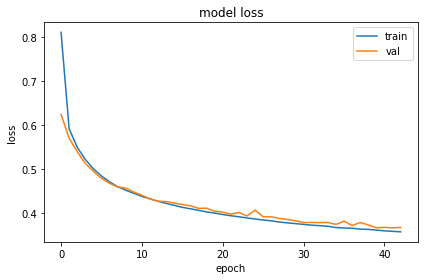

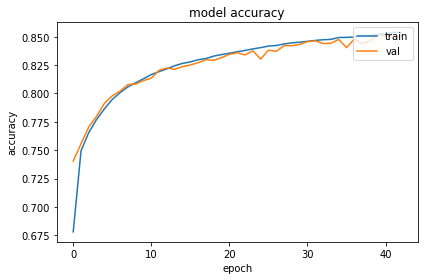

model's loss  0.3669198751449585
model's accuracy  0.8510968089103699
                   precision    recall  f1-score   support

       Spruce/Fir       0.87      0.82      0.84     42368
   Lodgepole Pine       0.85      0.90      0.88     56661
   Ponderosa Pine       0.81      0.85      0.83      7151
Cottonwood/Willow       0.78      0.70      0.74       549
            Aspen       0.71      0.48      0.58      1899
      Douglas-fir       0.69      0.62      0.65      3473
        Krummholz       0.86      0.87      0.86      4102

         accuracy                           0.85    116203
        macro avg       0.80      0.75      0.77    116203
     weighted avg       0.85      0.85      0.85    116203



<Figure size 432x288 with 0 Axes>

In [38]:
if __name__ == '__main__':
    main()